In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pyerrors as pe

In [10]:
plt.style.use('./base_style.mplstyle')
plt.rc('text', usetex=True)

A correlator can not only contain a list of Obs, but also a list of matrices of obs. 
This is useful, if there are multiple sources and sinks used. In our example, the sources have a different Gaussian smearing applied. 

We will load such a correlator.

In [11]:
matrix_V1V1 = pe.input.json.load_json("./data/matrix_correlator_V1V1")

Data has been written using pyerrors 2.0.0+dev.
Format version 0.1
Written by jan on 2022-01-27 10:49:51 +0100 on host endwings, Linux-5.13.0-27-generic-x86_64-with-glibc2.10


We can print the content at timeslice 0. As we can see, it is a matrix of Obs. 

In [12]:
print(matrix_V1V1.content[0])

[[Obs[0.9521372299563664] Obs[0.012396221358945024]
  Obs[0.005964522290444636] Obs[0.00271868582032491]]
 [Obs[0.012406080421737313] Obs[0.004389377599144552]
  Obs[0.0026720900942348203] Obs[0.0014322792739559524]]
 [Obs[0.00597528112202714] Obs[0.0026722311560493962]
  Obs[0.0017410144722897988] Obs[0.0009900129922259138]]
 [Obs[0.002728787039125839] Obs[0.001432511366233049]
  Obs[0.0009901084333529782] Obs[0.0005964594911910594]]]


Let us try to get the effective mass. 

In [13]:
try:
    matrix_V1V1.m_eff() #This does not work! 
except:
    print("Something is wrong")

Something is wrong


Many methods we could use for regular correlators do not work with matrix-correlators. 
In order to get the effective mass, we need to convert to a regular correlator first. 

One way to do it, is to pick an element out of the matrix:

In [14]:
single_smearing = matrix_V1V1.item(0,0)

**Corr.index(i,j)** picks the element [i,j] from every matrix and returns a correlator containing one Obs per timeslice. 
But there is a more usefull way to retrieve a single value per timeslice. 
We might want a linear combination of different sources and sinks. 
We can formalize this as

$$C_{\textrm{projected}}(t)=v_1^T \underline{C}(t) v_2$$

If we choose the vectors to be $v_1=v_2=(0,1,0,0)$, we should get the same correlator as in the cell above. 

Thinking about it this way is usefull in the Context of the generalized eigenvalue problem (GEVP), used to find the source-sink combination, which best describes a certain energy eigenstate.
A good introduction is found in https://arxiv.org/abs/0902.1265.

In [15]:
vec = matrix_V1V1.GEVP(t0=3,ts=6,state=0)
assert len(vec) == matrix_V1V1.N
print(vec)

[  -0.71920537  162.3903938  -492.21321233  714.06804297]


As we see, the eigenvector is of length **matrix_V1V1.N** and contains regular floats. 
We can use it to project the correlator. 

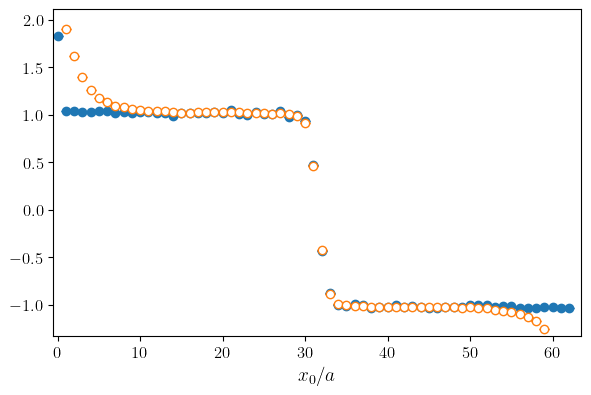

In [20]:
matrix_V1V1.projected(vec).m_eff().show(comp=single_smearing.m_eff(),auto_gamma=True)

There is a lot going on in this line of code. 
We start with our matrix correlator and we project it, using the vector we got from the GEVP routine. 

This gives us a new correlator with one Obs per timeslice. We then calculate its effective mass and plot it. 
We tell the **Corr.show** method to show another correlator as a comparison. 

We can see, that the projected correlator (*blue*) converges to a mass plateau much quicker than the single smearing level.

## Example Analysis

We can use what we learned so far to perform an actually usefull analysis. 
The correlator **matrix_V1V1** we looked at corresponds to vector-charmonium. 

We might be interested in the mass of the $J/\Psi$ state.

Data has been written using pyerrors 2.0.0+dev.
Format version 0.1
Written by jan on 2022-01-27 10:49:51 +0100 on host endwings, Linux-5.13.0-27-generic-x86_64-with-glibc2.10
Data has been written using pyerrors 2.0.0+dev.
Format version 0.1
Written by jan on 2022-01-27 10:49:51 +0100 on host endwings, Linux-5.13.0-27-generic-x86_64-with-glibc2.10
Fit with 1 parameter
Method: Levenberg-Marquardt
`ftol` termination condition is satisfied.
chisquare/d.o.f.: 0.6929473279421142
--- The mass was calculated to be 3079.8(7.9) MeV ---


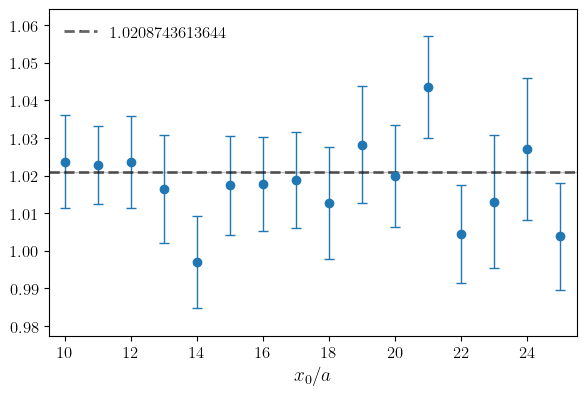

In [9]:
# We do not just have V1V1, but also the two other spacial directions. We can average over them for better statistics. 
matrix_V2V2= pe.input.json.load_json("./data/matrix_correlator_V2V2")
matrix_V3V3= pe.input.json.load_json("./data/matrix_correlator_V3V3")
matrix_VnVn=(matrix_V1V1 + matrix_V2V2 + matrix_V3V3) / 3. 

#We then solve the GEVP to get eigenvectors corresponding to the ground state. 

vec_ground = matrix_VnVn.GEVP(t0=3, ts=6, state=0)

#Now we project the matrix-correlators to get new correlators belonging to the ground state.

corr_ground = matrix_VnVn.projected(vec_ground)

# We get the effective mass using the periodic cosh method. 
m_eff_Jpsi = corr_ground.m_eff(variant="cosh")

# We can now pick a plateau range and get a single value for the mass. 
m_eff_Jpsi.gamma_method()
m_Jpsi = m_eff_Jpsi.plateau([5, 24])

# We can now visually compare our plateau value to the data

m_eff_Jpsi.show([10, 25], plateau=m_Jpsi,)

# Since the lattice spacing is known, we can multiply with hbar*c/a to see it in physical units 

m_Jpsi = m_Jpsi * 197 / 0.0653

#As a last step we call the gamma method to get the error 

m_Jpsi.gamma_method()

print("--- The mass was calculated to be" , m_Jpsi, "MeV ---")